# <div align="center">Analysis of Job Postings and Employment Levels in Swing States of the 2020 Presidential Election</div> #


**<div align="center">Barrett Nibling</div>**
**<div align="center">bnibling@gmail.com</div>**

There is no question that we are living in turbulent times. With the country in the midst of an unprecedented pandemic, millions of Americans were laid off and forced into unemployment as states across the land felt the rippling effects of COVID-19 and the subsequent lockdown. According to the U.S. Bureau of Labor Statistics, the national unemployment rate nearly reached 15% (14.7%) earlier this year (Apr-2020). While these numbers have been trending back toward pre-COVID levels in recent months, will this growth be enough to convince voters in swing states that the economy will fully recover under the current administration or could this be a measure to indicate which of these states will flip sides come November’s election?


This project will analyze the Opportunity Insights Economic Tracker repository to explore and find any trending behaviors in the data sets pertaining to the swing states in the upcoming 2020 presidential election. The research will focus on two data sets provided in the repository:

·  	State-level Job Postings- data from Burning Glass Technologies

·  	State-level Employment Levels- data from Paychex, Earnin, and Intuit

 
The Job Postings data set provides the weekly count of new job postings relative to the January 2020 index period for each state and breaks the data down by industry, educational requirement, and combined. The Employment Levels data set provides the daily number of active employees relative to the January 2020 index period for each state and breaks the data down by wage, industry, and combined. The values in these two data sets are often indicative of the strength of the job market.

Through this study, the hope is to provide statistical insight on the strength of the job market in the nine states that the 2020 Election Forecast on FiveThirtyEight.com (https://projects.fivethirtyeight.com/2020-election-forecast/) has determined as the “states with the closest races”. These nine states are: Arizona, Florida, Georgia, Iowa, North Carolina, Ohio, Pennsylvania, Texas, and Wisconsin. To do so, this report will show comparative analysis with these data sets in order to answer the following questions:

1. 	When compared to non-swing states, do these states show a significant difference in job postings and employment levels?

>* H<sub>o</sub>  : There is no difference between average job postings in swing states and non-swing states in 2020. 

>* H<sub>a</sub>  : Swing states have a lower average job postings than non-swing states


>* H<sub>o</sub>  : There is no difference between average employment levels in swing states and non-swing states in 2020. 

>* H<sub>a</sub>  : Swing states have a lower average employment levels than non-swing states


2. 	When compared to each other, do these swings states differ from each other in job postings and employment levels?

>* H<sub>o</sub>  : There is no difference in average job postings between individual swing states in 2020. 

>* H<sub>a</sub>  : There is a significant difference in average job postings between at least one individual swing state in 2020.

>* H<sub>o</sub>  : There is no difference in average employment levels between individual swing states in 2020. 

>* H<sub>a</sub>  : There is a significant difference in average employment levels between at least one individual swing state in 2020.
 
In order to answer these questions, the data will be split into two groups, swing states and non-swing states. Then, the distribution of the averages for both job postings and employment levels will be analyzed using one of the independent groups A/B test methods depending on the normality of the distribution. If normality is proven, the t-test for independent samples will be used for research question one and the One-way ANOVA test will be used for research question two. If the distributions are not normal, then a non-parametric test such as Kruskal-Wallis or Mann-Whitney U tests will be performed. With these tests, the hypotheses can either be confirmed or rejected depending on the resulting p-values. Additionally, visualizations of the distributions using distribution plots and visualizations of trends over time using line or scatter plots will be provided to give further insight on the data. The answers to these questions could potentially show if there is a connection between being a swing state and job market strength, and may provide inferences to the outcomes of election night from these nine states. 


## Opportunity Insights Economic Tracker Repository, Data Documentation, and Dictionary

The Opportunity Insights Economic Tracker Repository can be found on github through the following link: https://github.com/OpportunityInsights/EconomicTracker

Documentation about the Repository: https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_documentation.md

Data Dictionary: https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_dictionary.md


**Note: The data used for this report was last pull from the repository on September 28, 2020 12:00:00 EST**

In [1]:
# import libraries here
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# csv file locations
job_st_data = './EconomicTracker/data/Burning Glass - State - Weekly.csv'
emp_st_data = './EconomicTracker/data/Employment Combined - State - Daily.csv'
geo_st_data = './EconomicTracker/data/GeoIDs - State.csv'

In [3]:
# create pandas DataFrames of csv files
job_st_df = pd.read_csv(job_st_data)
emp_st_df = pd.read_csv(emp_st_data) 
geo_st_df = pd.read_csv(geo_st_data) 

## Organize Data and Exploratory Analysis

In this section, the GeoID data will be merged with both the job postings and employment levels dataframes. Additionally, the columns containing values for `year`, `month`, and `day` will be combined into a `date` field.

For this initial analysis, only `bg_posts` from the job postings dataframe and `emp_combined` from the employment levels dataframe will be investigated. These 2 fields will help make an overall generalization of the data contained in each data set as they are averages of the other columns combined.

In [4]:
# take a look at the GeoID df
geo_st_df.head()

,statefips,statename,stateabbrev,state_pop2019
0,1,Alabama,AL,4903185
1,2,Alaska,AK,731545
2,4,Arizona,AZ,7278717
3,5,Arkansas,AR,3017804
4,6,California,CA,39512223


In [5]:
# merge GeoID data and job postings data, combine year, month, day into date, and drop unused columns
job_st_df = pd.merge(job_st_df, geo_st_df, on='statefips')
job_st_df= job_st_df.rename(columns={"day_endofweek": "day"})
job_st_df['date'] = pd.to_datetime(job_st_df[['year', 'month', 'day']])
job_st_df = job_st_df[['date', 'bg_posts', 'stateabbrev', 'statename', 'state_pop2019', 'statefips']]

In [6]:
# initial look at the job postings df
job_st_df.info()
job_st_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1887 entries, 0 to 1886
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1887 non-null   datetime64[ns]
 1   bg_posts       1887 non-null   float64       
 2   stateabbrev    1887 non-null   object        
 3   statename      1887 non-null   object        
 4   state_pop2019  1887 non-null   int64         
 5   statefips      1887 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 103.2+ KB


,date,bg_posts,stateabbrev,statename,state_pop2019,statefips
0,2020-02-07,0.4370,AL,Alabama,4903185,1
1,2020-02-28,0.0195,AL,Alabama,4903185,1
2,2020-06-19,-0.1400,AL,Alabama,4903185,1
3,2020-05-22,-0.1330,AL,Alabama,4903185,1
4,2020-01-31,0.0079,AL,Alabama,4903185,1


In [7]:
# repeat for employment levels data
emp_st_df = pd.merge(emp_st_df, geo_st_df, on='statefips')
emp_st_df['date'] = pd.to_datetime(emp_st_df[['year', 'month', 'day']])
emp_st_df = emp_st_df[['date', 'emp_combined', 'stateabbrev', 'statename', 'state_pop2019', 'statefips']]

In [8]:
# initial look at the employment levels df
emp_st_df.info()
emp_st_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10047 entries, 0 to 10046
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           10047 non-null  datetime64[ns]
 1   emp_combined   10047 non-null  float64       
 2   stateabbrev    10047 non-null  object        
 3   statename      10047 non-null  object        
 4   state_pop2019  10047 non-null  int64         
 5   statefips      10047 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 549.4+ KB


,date,emp_combined,stateabbrev,statename,state_pop2019,statefips
0,2020-01-15,0.001970,AL,Alabama,4903185,1
1,2020-01-16,0.001220,AL,Alabama,4903185,1
2,2020-01-17,0.000464,AL,Alabama,4903185,1
3,2020-01-18,-0.000228,AL,Alabama,4903185,1
4,2020-01-19,-0.000920,AL,Alabama,4903185,1


With the dataframes for job postings and employment levels by state prepared, it is now time to take an initial look at the data visually in order to get a rough idea of what the distributions look like. 

The plots below for each data set are a line plot that shows the trends versus date of both average job postings and average employment levels over the last year and a distribution plot that shows the distribution of averages in each data set. 

In addition to the visualizations, descriptive statistics are shown to check normality for each distribution. These checks include QQ plots and descriptive statistics values such as variance, skewness, and kurtosis.

### Exploratory Analysis of Job Postings Data###

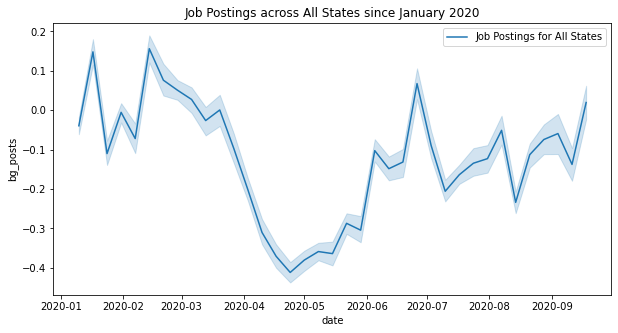

In [9]:
# line plot of the job postings df to see how the average percent of job postings changed in 2020
plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='bg_posts', data=job_st_df, label='Job Postings for All States')
plt.title('Job Postings across All States since January 2020')
plt.legend()
plt.show()

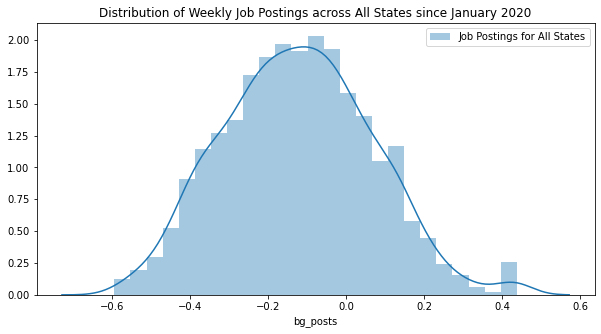

In [10]:
# normality check 1- distribution plot of average job postings in 2020
# check to see if the distribution appears visibly normal
plt.figure(figsize=(10,5))
sns.distplot(job_st_df['bg_posts'], label='Job Postings for All States')
plt.title('Distribution of Weekly Job Postings across All States since January 2020')
plt.legend()
plt.show()

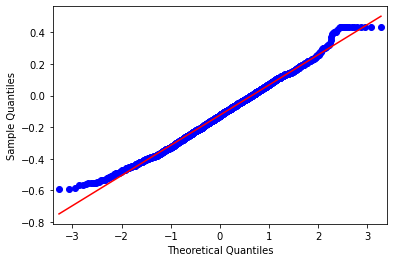

In [11]:
# normality check 2- QQ plot
# if the distribution is normal, the relationship will be linear
sm.qqplot(job_st_df['bg_posts'].sort_values(), line = 'r')
plt.show()

In [12]:
# normality check 3- Variance, Skewness, and Kurtosis check
# values for skewness and kurtosis should be minimal for normality (between -1 to 1 is ideal)
print('Normality checks for State-level Job Postings:')
print(stats.describe(job_st_df['bg_posts']))

Normality checks for State-level Job Postings:
DescribeResult(nobs=1887, minmax=(-0.594, 0.43700000000000006), mean=-0.12328600105988341, variance=0.03645690959028844, skewness=0.1835005589627948, kurtosis=-0.18042087841941168)


For the job postings data, the distribution plot appears to be fairly normal. The QQ plot, and the skewness and kurtosis values from the other normality checks confirm this. Therefore, it is a reasonable assumption going forward that the distribution is normal for this data set. 

### Exploratory Analysis of Employment Levels Data###

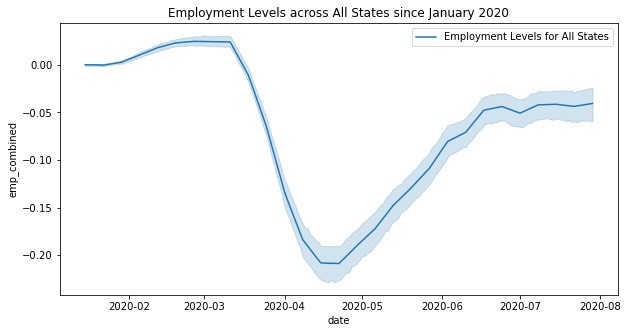

In [13]:
# line plot of the employment df to see how the average percent of employment levels changed in 2020
plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='emp_combined', data=emp_st_df, label='Employment Levels for All States')
plt.title('Employment Levels across All States since January 2020')
plt.legend()
plt.show()

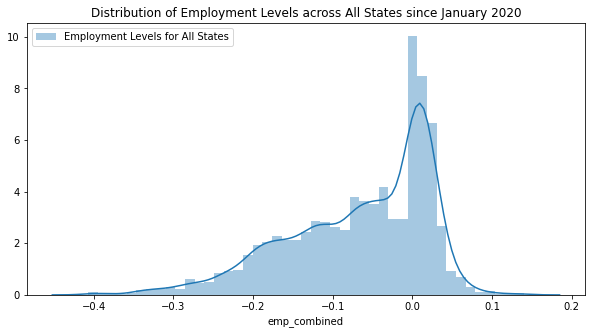

In [14]:
# normality check 1- distribution plot of average employment levels in 2020
# check to see if the distribution appears visibly normal
plt.figure(figsize=(10,5))
sns.distplot(emp_st_df['emp_combined'], label='Employment Levels for All States')
plt.title('Distribution of Employment Levels across All States since January 2020')
plt.legend()
plt.show()

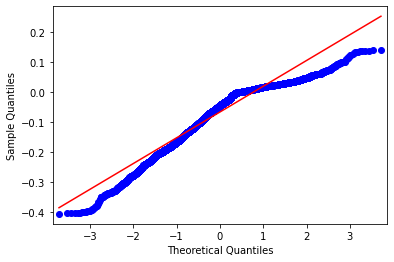

In [15]:
# normality check 2- QQ plot
# if the distribution is normal, the relationship will be linear
sm.qqplot(emp_st_df['emp_combined'].sort_values(), line = 'r')
plt.show()

In [16]:
# normality check 3- Variance, Skewness, and Kurtosis check
# values for skewness and kurtosis should be minimal for normality (between -1 to 1 is ideal)
print('Normality checks for State-level Employment Levels:')
print(stats.describe(emp_st_df['emp_combined']))

Normality checks for State-level Employment Levels:
DescribeResult(nobs=10047, minmax=(-0.40700000000000003, 0.14), mean=-0.06664430350154275, variance=0.007935773296263495, skewness=-0.839652800908511, kurtosis=0.14993938732424095)


Interestingly, the line plots for both job postings and employment levels appear to follow a similar trend. In future studies, it would be interesting to see if there is a significant correlation between job postings and employment levels. 

The distribution plots for each are very different however. For the employment levels data, the distribution plot does not appear to be normal. Even though the skewness and kurtosis values are within acceptable values for normality, the sharp peak just positive of zero and negative tail would indicate that this distribution is not normal. Additionally, the QQ plot doesn't prove a linear relationship with a normal distribution. Therefore, it is a reasonable assumption going forward that the distribution is not normal for this data set. 

###  Swing States vs Non-Swing States###

In order to compare swing states and non-swing states, a new column needs to be added to the dataframes to indicate whether each state is a swing state or not.

In the beginning, it said that the states with the closest races are: Arizona, Florida, Georgia, Iowa, North Carolina, Ohio, Pennsylvania, Texas, and Wisconsin.

Let's add a column to each dataframe named `is_swing` and set the value of `1` for all data that are from one of the swing states and the value of `0` for all data from non-swing states.

In [17]:
# extract the GeoIDs for each of the swings states
geo_swing_states = geo_st_df.loc[[2, 9, 10, 15, 33, 35, 38, 43, 49], : ]
geo_swing_states

,statefips,statename,stateabbrev,state_pop2019
2,4,Arizona,AZ,7278717
9,12,Florida,FL,21477737
10,13,Georgia,GA,10617423
15,19,Iowa,IA,3155070
33,37,North Carolina,NC,10488084
35,39,Ohio,OH,11689100
38,42,Pennsylvania,PA,12801989
43,48,Texas,TX,28995881
49,55,Wisconsin,WI,5822434


In [18]:
# create a column `is_swing` where the value of 1 is a swing state and 0 is a non-swing state
job_st_df['is_swing'] = np.where(job_st_df['statename'].isin(geo_swing_states['statename']), 1, 0)

In [19]:
job_st_df['statename'].loc[job_st_df['is_swing']==1].unique()

array(['Arizona', 'Florida', 'Georgia', 'Iowa', 'North Carolina', 'Ohio',
       'Pennsylvania', 'Texas', 'Wisconsin'], dtype=object)

In [20]:
# repeat the same for employment levels df
emp_st_df['is_swing'] = np.where(emp_st_df['statename'].isin(geo_swing_states['statename']), 1, 0)

In [21]:
emp_st_df['statename'].loc[emp_st_df['is_swing']==1].unique()

array(['Arizona', 'Florida', 'Georgia', 'Iowa', 'North Carolina', 'Ohio',
       'Pennsylvania', 'Texas', 'Wisconsin'], dtype=object)

In [22]:
# make some shortcut dfs so don't need to use the loc function each time
s_job_df = job_st_df.loc[job_st_df['is_swing']==1]
ns_job_df = job_st_df.loc[job_st_df['is_swing']==0]

s_emp_df = emp_st_df.loc[emp_st_df['is_swing']==1]
ns_emp_df = emp_st_df.loc[emp_st_df['is_swing']==0]

## Research Question 1#

This part will compare non-swing states and swing states to see if there is a significant difference in job postings and employment levels, and doing so will test the following hypotheses:

>* H<sub>o</sub>  : There is no difference between average job postings in swing states and non-swing states in 2020. 

>* H<sub>a</sub>  : Swing states have a lower average job postings than non-swing states


>* H<sub>o</sub>  : There is no difference between average employment levels in swing states and non-swing states in 2020. 

>* H<sub>a</sub>  : Swing states have a lower average employment levels than non-swing states


### Swing States vs Non-Swing States: Job Postings

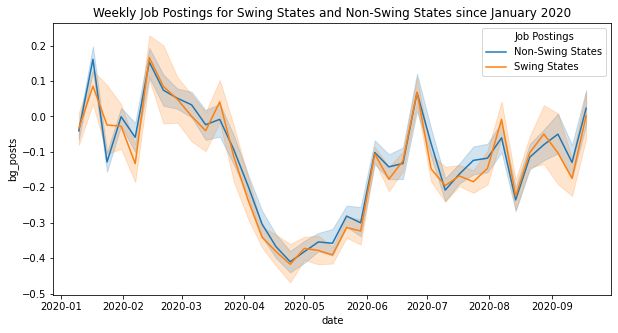

In [23]:
# line plot of the job postings df to see if job postings between swing states and non-swing states changes over 2020
plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='bg_posts', hue='is_swing', data=job_st_df)
plt.title('Weekly Job Postings for Swing States and Non-Swing States since January 2020')
plt.legend(title='Job Postings', loc='upper right', labels=['Non-Swing States', 'Swing States'])
plt.show()

From this initial visualization, it appears that average job posting trends for both swing states and non-swings states are similar. This is somewhat expected as job postings don't determine whether a state is a swing state or not.

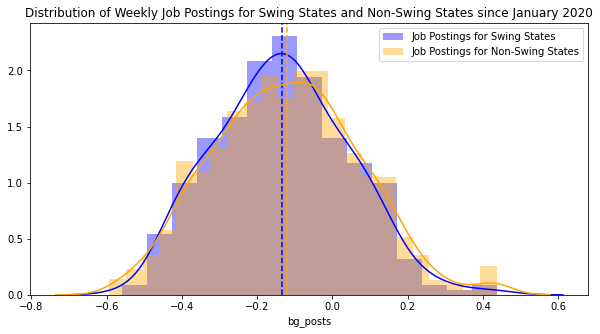

In [24]:
# normality check 1- distribution plot of average job postings for swing states and non-swing states
plt.figure(figsize=(10,5))
sns.distplot(s_job_df['bg_posts'], color='blue', label='Job Postings for Swing States')
plt.axvline(x=s_job_df['bg_posts'].mean(), color='blue', ls='dashed')
sns.distplot(ns_job_df['bg_posts'], color='orange', label='Job Postings for Non-Swing States')
plt.axvline(x=ns_job_df['bg_posts'].mean(), color='orange', ls='dashed')
plt.title('Distribution of Weekly Job Postings for Swing States and Non-Swing States since January 2020')
plt.legend()
plt.show()

Like the previous plot, the distributions for both swing states and non-swing states appear to be similar in shape. The main difference is that the swing state distribution does appear to be shifted slightly to the left towards the negative values and the mean value of the distribution is less than the mean value for non-swing states.

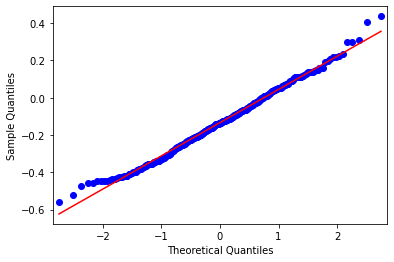

In [25]:
# Normality check 2- QQ plot for job postings in swing states
sm.qqplot(s_job_df['bg_posts'].sort_values(), line = 'r')
plt.show()

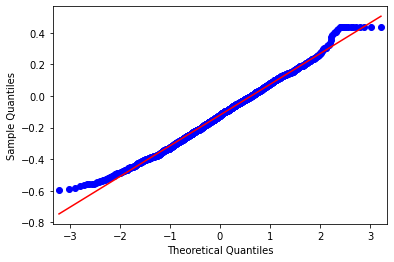

In [26]:
# Normality check 2- QQ plot for job postings in non-swing states
sm.qqplot(ns_job_df['bg_posts'].sort_values(), line = 'r')
plt.show()

In [27]:
# Normality check 3- Variance, Skewness and Kurtosis for job postings in swing states
print('Normality checks for Swing States Job Postings:')
print(stats.describe(s_job_df['bg_posts']))

Normality checks for Swing States Job Postings:
DescribeResult(nobs=333, minmax=(-0.5589999999999999, 0.43700000000000006), mean=-0.13359321321321324, variance=0.031093046893559826, skewness=0.21315165630781885, kurtosis=-0.19704464111249775)


In [28]:
# Normality check 3- Variance, Skewness and Kurtosis for job postings in non-swing states
print('Normality checks for Non-Swing States Job Postings:')
print(stats.describe(ns_job_df['bg_posts']))

Normality checks for Non-Swing States Job Postings:
DescribeResult(nobs=1554, minmax=(-0.594, 0.43700000000000006), mean=-0.12107731274131274, variance=0.03759940861095815, skewness=0.17260203925939283, kurtosis=-0.19357872864710046)


Both of these distributions pass these normality checks. Both appear to have a linear relationship on the QQ plots, their variances are approximately the same, and their skewness and kurtosis values are minimal. It can be assumed that these distributions are both normal. Therefore, a t-test for independent samples can be used to compare the means of both distributions to see if the difference observed in the distribution plot is significant.

In [29]:
# independent samples t-test for job postings in swing states vs non-swing states 
print('Standard t-test:')
print(stats.ttest_ind(s_job_df['bg_posts'], ns_job_df['bg_posts'], equal_var=True))
print('Welch\'s t-test:')
print(stats.ttest_ind(s_job_df['bg_posts'], ns_job_df['bg_posts'], equal_var=False))

Standard t-test:
Ttest_indResult(statistic=-1.0855614028465315, pvalue=0.2778118914332182)
Welch's t-test:
Ttest_indResult(statistic=-1.1542981109180694, pvalue=0.24890929913209672)


Though the variances are similar, the number of observations for each distribution is quite different. To account for this, both the standard t-test and the Welch's t-test were performed. 

The p-value from these tests is 0.277 for the standard t-test and 0.249 using Welch's t-test. Both of these results are greater than 0.05 and indicative that the difference in means between average job postings in swing states and non-swing states is not significant. Therefore, the null hypothesis that there is any difference between average job postings in swing states and non-swing states in 2020 cannot be rejected.

### Swing States vs Non-Swing States: Employment Levels

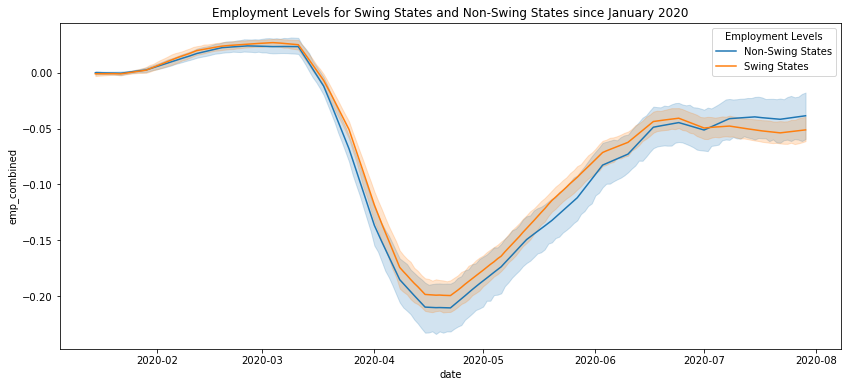

In [30]:
# line plot of the employment df to see if employment levels between swing states and non-swing states 
# changes over 2020
plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='emp_combined', hue='is_swing', data=emp_st_df)
plt.title('Employment Levels for Swing States and Non-Swing States since January 2020')
plt.legend(title='Employment Levels', loc='upper right', labels=['Non-Swing States', 'Swing States'])
plt.show()

Like the line plot for job postings, it appears that the employment level trends for both swing states and non-swings are similar and consistently within each other's KDE. 

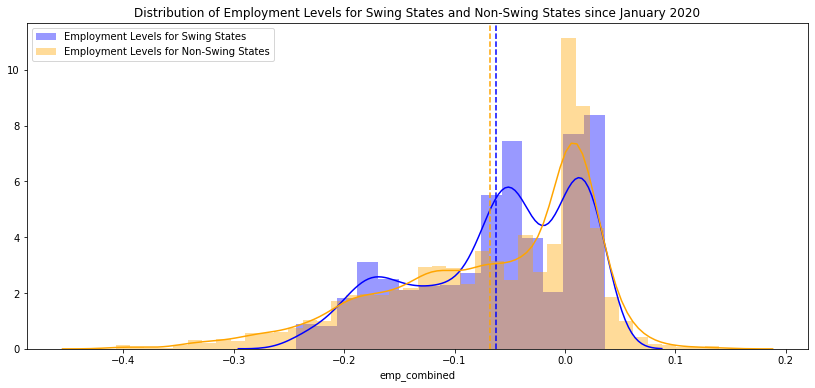

In [31]:
# normality check 1- distribution plot of employment levels for swing states and non-swing states
plt.figure(figsize=(14,6))
sns.distplot(s_emp_df['emp_combined'], color='blue', label='Employment Levels for Swing States')
plt.axvline(x=s_emp_df['emp_combined'].mean(), color='blue', ls='dashed')
sns.distplot(ns_emp_df['emp_combined'], color='orange', label='Employment Levels for Non-Swing States')
plt.axvline(x=ns_emp_df['emp_combined'].mean(), color='orange', ls='dashed')
plt.title('Distribution of Employment Levels for Swing States and Non-Swing States since January 2020')
plt.legend()
plt.show()

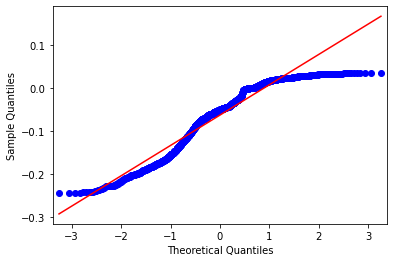

In [32]:
# Normality check 2- QQ plot for employment levels in swing states
sm.qqplot(s_emp_df['emp_combined'].sort_values(), line = 'r')
plt.show()

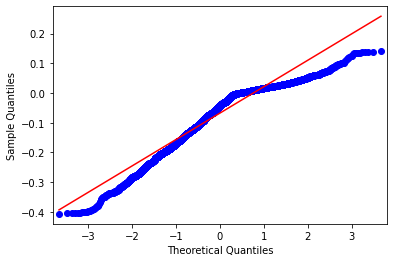

In [33]:
# Normality check 2- QQ plot for employment levels in non-swing states
sm.qqplot(ns_emp_df['emp_combined'].sort_values(), line = 'r')
plt.show()

In [34]:
# Normality check 3- Variance, Skewness and Kurtosis for employment levels in swing states
print('Normality checks for State-level Job Postings:')
print(stats.describe(s_emp_df['emp_combined']))

Normality checks for State-level Job Postings:
DescribeResult(nobs=1773, minmax=(-0.244, 0.0359), mean=-0.06238221390862944, variance=0.005313608886874, skewness=-0.5890180133914453, kurtosis=-0.7069942561078233)


In [35]:
# Normality check 3- Variance, Skewness and Kurtosis for employment levels in non-swing states
print('Normality checks for State-level Job Postings:')
print(stats.describe(ns_emp_df['emp_combined']))

Normality checks for State-level Job Postings:
DescribeResult(nobs=8274, minmax=(-0.40700000000000003, 0.14), mean=-0.06755760841430988, variance=0.008493648587148269, skewness=-0.8472920520400645, kurtosis=0.12263025969347918)


Both of these distributions fail to pass the normality checks. Visually they do not appear normal and the QQ plots do not show a linear relationship with a normal distribution, even though their skewness and kurtosis values are relatively small. It can be assumed that these distributions are not normal, and therefore, a non-parametric test for independent samples will be used to compare the means of both distributions, namely the Mann-Whitney U test and Kruskal-Wallis test.

In [36]:
print(stats.mannwhitneyu(s_emp_df['emp_combined'], ns_emp_df['emp_combined']))
print(stats.kruskal(s_emp_df['emp_combined'], ns_emp_df['emp_combined']))

MannwhitneyuResult(statistic=7297307.0, pvalue=0.36723071447687045)
KruskalResult(statistic=0.11505757539408203, pvalue=0.7344580306279134)


The p-values from both of these tests is greater than 0.05. This indicates that there is no significant difference in means between average employment levels in swing states and non-swing states. Therefore, the null hypothesis that there is any difference between average employment levels in swing states and non-swing states is 2020 cannot be rejected.

### Research Question 1 Conclusion

For both distributions, job postings and employment levels, the null hypotheses failed to be rejected. There is not enough statistical significance to declare these values differ between swing states and non-swing states. This is somewhat expected as there are many factors determining whether a state is a swing state or not, and job postings and employment levels weren't likely to be the determinate factors to make this decision. 

## Research Question 2#


This part will address research question 2, do swing states share commonality with each other in job postings and employment levels? The following hypotheses will be tested in order to answer this:

>* H<sub>o</sub>  : There is no difference in average job postings between individual swing states in 2020. 

>* H<sub>a</sub>  : There is a significant difference in average job postings between at least one individual swing state in 2020.

>* H<sub>o</sub>  : There is no difference in average employment levels between individual swing states in 2020. 

>* H<sub>a</sub>  : There is a significant difference in average employment levels between at least one individual swing state in 2020.

### Swing State vs Swing State: Job Postings###

In [37]:
# create a dictionary of df for each swing state using `stateabbrev` as keys
s_job_dict = {i: job_st_df.loc[job_st_df['stateabbrev'] == i] for i in geo_swing_states['stateabbrev']}

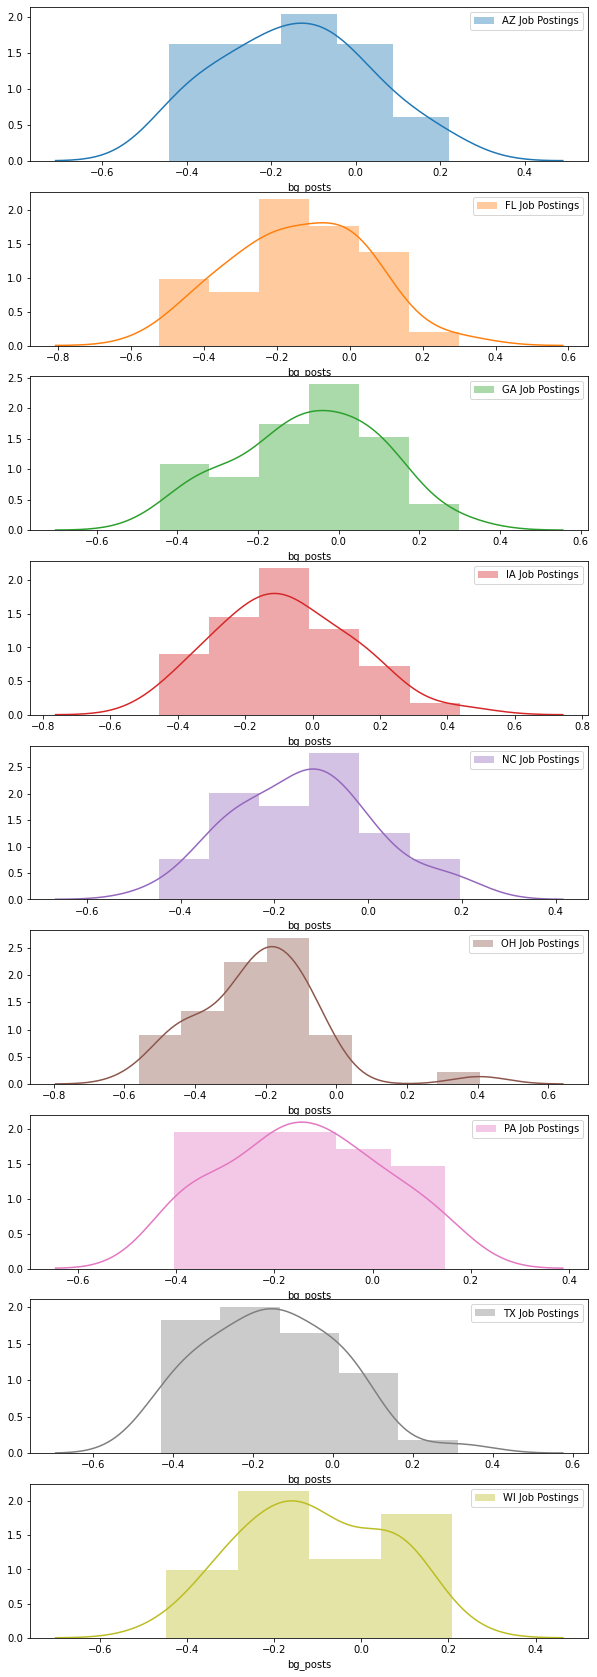

In [38]:
# normality check 1- plot the distribution of each swing state
colors = plt.rcParams["axes.prop_cycle"]()
rows = len(s_job_dict.keys())
fig, axes = plt.subplots(rows, 1, figsize=(10, 30))
row = 0
for i in s_job_dict.keys():
    c = next(colors)["color"]
    sns.distplot(s_job_dict[i]['bg_posts'], color=c, ax=axes[row], label='{} Job Postings'.format(i))
    axes[row].legend()
    row += 1
    
plt.show()

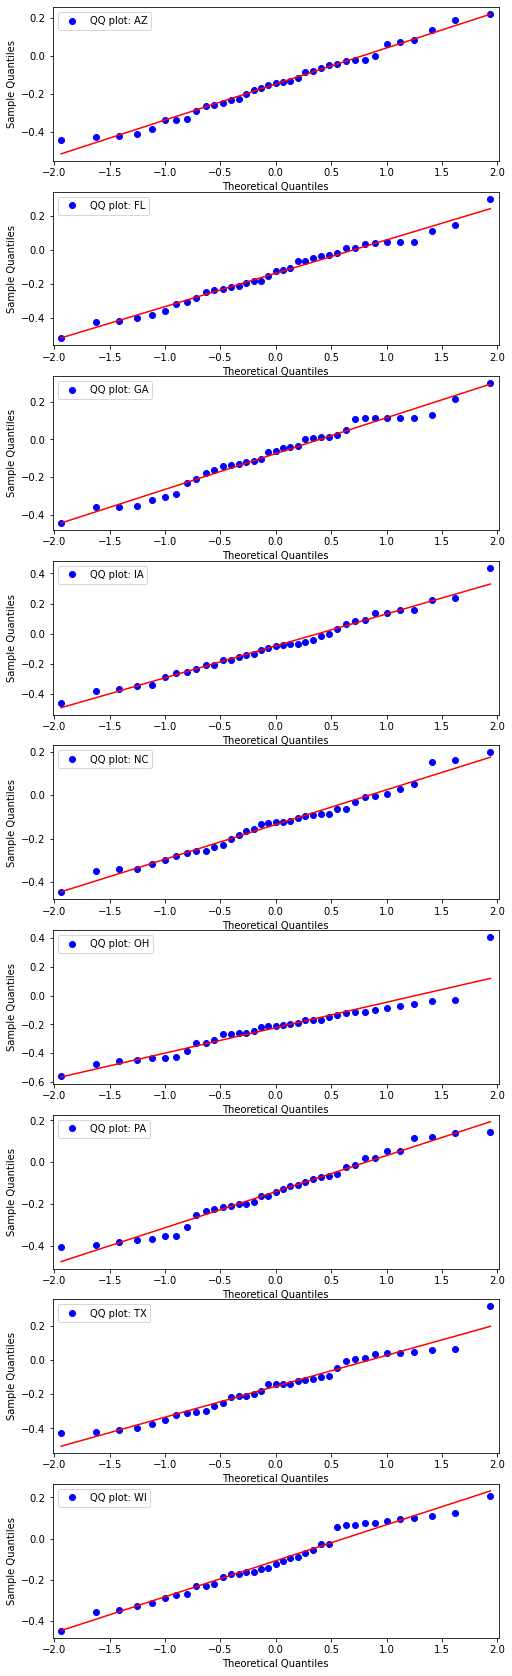

In [39]:
# normality check 2- plot the QQ plot for each swing state vs a normal distribution
rows = len(s_job_dict.keys())
fig, axes = plt.subplots(rows, 1, figsize=(8, 30))
row = 0
for i in s_job_dict.keys():
    sm.qqplot(s_job_dict[i]['bg_posts'].sort_values(), line = 'r', ax=axes[row], label='QQ plot: {}'.format(i))
    axes[row].legend()
    row += 1
    
plt.show()

In [40]:
# normality check 3- Variance, Skewness, and Kurtosis for each swing state
s_job_describe_dict = {i:np.array(stats.describe(s_job_dict[i]['bg_posts'])) for i in s_job_dict.keys()}
s_job_describe_df = pd.DataFrame.from_dict(s_job_describe_dict, orient='index', 
                               columns=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis'])
s_job_describe_df

,nobs,minmax,mean,variance,skewness,kurtosis
AZ,37,"(-0.441, 0.221)",-0.146615,0.031225,0.142785,-0.714826
FL,37,"(-0.523, 0.301)",-0.138807,0.033780,0.003069,-0.431391
GA,37,"(-0.444, 0.298)",-0.075141,0.031747,-0.165481,-0.636605
IA,37,"(-0.457, 0.43700000000000006)",-0.080589,0.039280,0.329528,-0.173847
NC,37,"(-0.447, 0.196)",-0.135166,0.022347,0.228099,-0.283829
OH,37,"(-0.5589999999999999, 0.405)",-0.222473,0.030007,0.889597,2.989655
PA,37,"(-0.405, 0.147)",-0.141268,0.026347,0.054415,-0.929989
TX,37,"(-0.43, 0.312)",-0.154567,0.029099,0.326670,-0.154138
WI,37,"(-0.44799999999999995, 0.209)",-0.107714,0.026991,-0.009629,-0.932396


All of the distributions appear to be relatively normal. They all mostly follow a linear relation to a normal distribution on the QQ plots, have similar variances, and are within tolerance for skewness and kurtosis. The only exception to this might be Ohio, as the kurtosis is almost 3 and there is abnormal value around 0.4. But visually, it looks to be normal enough to proceed. 

The next step is to perform a One-way ANOVA test to see if there are any statistical differences in the means of all the swing states.

In [41]:
stats.f_oneway(*[s_job_dict[i]['bg_posts'] for i in s_job_dict.keys()])

F_onewayResult(statistic=2.3813308752014097, pvalue=0.01665747125524078)

The p-value from the test above is 0.0166, which is less than 0.05. Therefore, at least one of the distributions is significantly from the other swing states. To see which state(s) differ, a Tukey's Honest Significant Differences (HSD) Test will be performed next on the distributions.

In [42]:
tukey_job = pairwise_tukeyhsd(endog= s_job_df['bg_posts'],
                         groups= s_job_df['stateabbrev'],
                         alpha= 0.05)

tukey_job.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
AZ,FL,0.0078,0.9,-0.1181,0.1338,False
AZ,GA,0.0715,0.6752,-0.0545,0.1974,False
AZ,IA,0.066,0.7565,-0.0599,0.192,False
AZ,NC,0.0114,0.9,-0.1145,0.1374,False
AZ,OH,-0.0759,0.6098,-0.2018,0.0501,False
AZ,PA,0.0053,0.9,-0.1206,0.1313,False
AZ,TX,-0.008,0.9,-0.1339,0.118,False
AZ,WI,0.0389,0.9,-0.087,0.1648,False
FL,GA,0.0637,0.7918,-0.0623,0.1896,False
FL,IA,0.0582,0.8731,-0.0677,0.1842,False


Almost all of the p-values are greater than 0.05, so there is no significant difference in the mean value of job postings between most of the swing states. 

However, two of the p-values were less than 0.05 and they were between Iowa and Ohio (p-value of 0.0145) and Georgia and Ohio (p-value of 0.0091). This means that with a 95% confidence interval Ohio had between 0.2678 to 0.0159 fewer average job postings than Iowa and 0.2733	to 0.0214 fewer average job postings than Georgia. 

This difference can clearly be seen in the distribution plots below. 

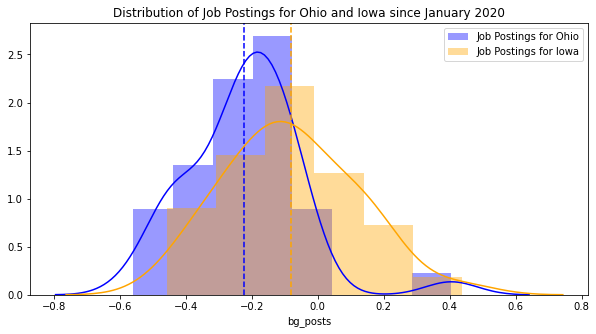

In [43]:
# distplot of job postings in Ohio vs Iowa
plt.figure(figsize=(10,5))
sns.distplot(s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='OH'], color='blue', label='Job Postings for Ohio')
plt.axvline(x=s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='OH'].mean(), color='blue', ls='dashed')
sns.distplot(s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='IA'], color='orange', label='Job Postings for Iowa')
plt.axvline(x=s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='IA'].mean(), color='orange', ls='dashed')
plt.title('Distribution of Job Postings for Ohio and Iowa since January 2020')
plt.legend()
plt.show()

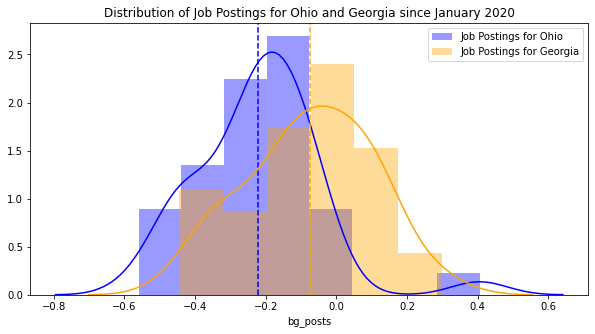

In [44]:
# distplot of job postings in Ohio vs Georgia
plt.figure(figsize=(10,5))
sns.distplot(s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='OH'], color='blue', label='Job Postings for Ohio')
plt.axvline(x=s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='OH'].mean(), color='blue', ls='dashed')
sns.distplot(s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='GA'], color='orange', label='Job Postings for Georgia')
plt.axvline(x=s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='GA'].mean(), color='orange', ls='dashed')
plt.title('Distribution of Job Postings for Ohio and Georgia since January 2020')
plt.legend()
plt.show()

When compared to all other states, and although it might not be significant in all cases, it is clear to see that Ohio is well behind the national average for job postings in 2020. 

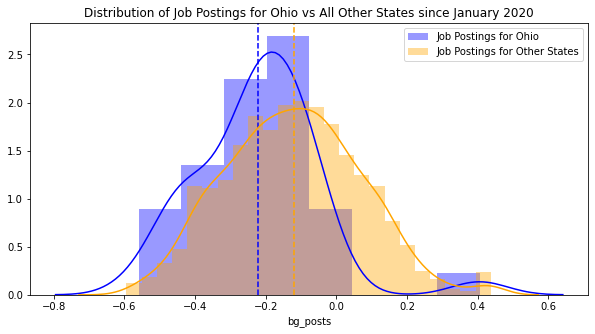

In [45]:
# distplot of job postings in Ohio vs All other states
plt.figure(figsize=(10,5))
sns.distplot(s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='OH'], color='blue', label='Job Postings for Ohio')
plt.axvline(x=s_job_df['bg_posts'].loc[s_job_df['stateabbrev']=='OH'].mean(), color='blue', ls='dashed')
sns.distplot(job_st_df['bg_posts'].loc[job_st_df['stateabbrev']!='OH'], color='orange', label='Job Postings for Other States')
plt.axvline(x=job_st_df['bg_posts'].loc[job_st_df['stateabbrev']!='OH'].mean(), color='orange', ls='dashed')
plt.title('Distribution of Job Postings for Ohio vs All Other States since January 2020')
plt.legend()
plt.show()

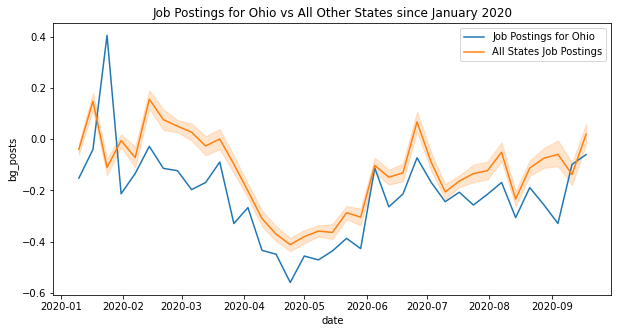

In [46]:
# lineplot of job postings trends in Ohio and all other states
plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='bg_posts', data=s_job_dict['OH'], label='Job Postings for Ohio')
sns.lineplot(x='date', y='bg_posts', data=job_st_df, label='All States Job Postings')
plt.title('Job Postings for Ohio vs All Other States since January 2020')
plt.legend()
plt.show()

Besides the random spike in the beginning of the year, which appears to be our previously mentioned outlier in the Ohio distribution, average job postings in Ohio is consistently below the national average throughout the entire year. 

In fact, it has the 4th lowest average job postings in the entire US and of the 5 worst states in job postings it has by far the largest population, making it an important state for this coming election.

In [47]:
job_st_df[['stateabbrev', 'bg_posts', 'state_pop2019', 'is_swing']].groupby('stateabbrev').mean().sort_values('bg_posts').reset_index().head(5)

,stateabbrev,bg_posts,state_pop2019,is_swing
0,ND,-0.266305,762062,0
1,WY,-0.231021,578759,0
2,DE,-0.228911,973764,0
3,OH,-0.222473,11689100,1
4,AR,-0.209846,3017804,0


### Swing State vs Swing State: Employment Levels###

In [48]:
# create a dictionary of df for each swing state using `stateabbrev` as keys
s_emp_dict = {i: emp_st_df.loc[emp_st_df['stateabbrev'] == i] for i in geo_swing_states['stateabbrev']}

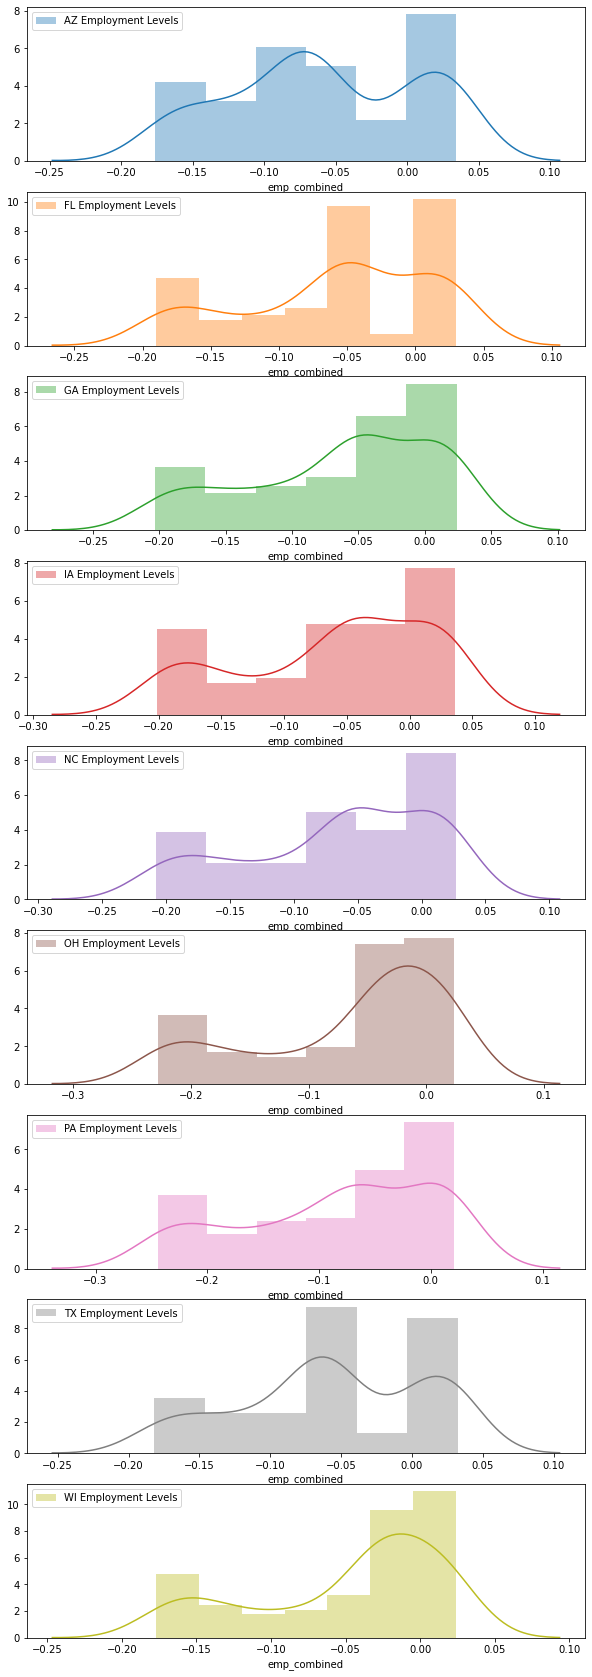

In [49]:
# normality check 1- plot the distribution of each swing state
colors = plt.rcParams["axes.prop_cycle"]()
rows = len(s_emp_dict.keys())
fig, axes = plt.subplots(rows, 1, figsize=(10, 30))
row = 0
for i in s_emp_dict.keys():
    c = next(colors)["color"]
    sns.distplot(s_emp_dict[i]['emp_combined'], color=c, ax=axes[row], label='{} Employment Levels'.format(i))
    axes[row].legend()
    row += 1
    
plt.show()

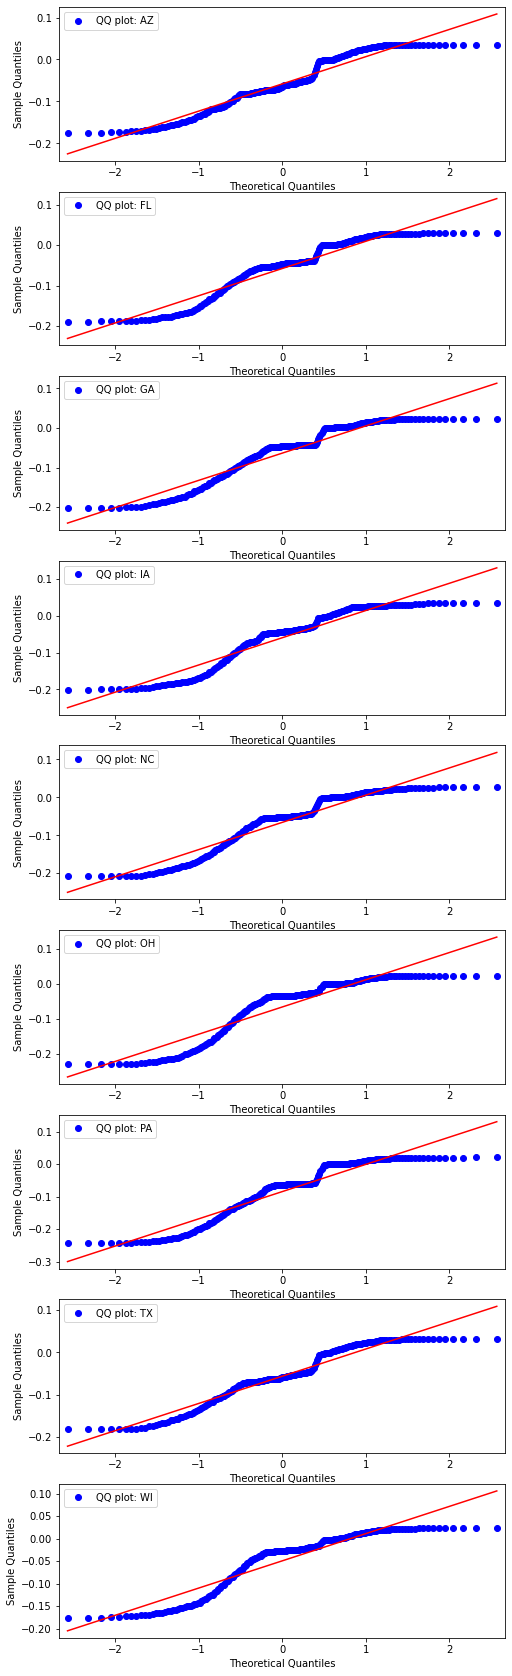

In [50]:
# normality check 2- plot the QQ plot for each swing state vs a normal distribution
rows = len(s_emp_dict.keys())
fig, axes = plt.subplots(rows, 1, figsize=(8, 30))
row = 0
for i in s_emp_dict.keys():
    sm.qqplot(s_emp_dict[i]['emp_combined'].sort_values(), line = 'r', ax=axes[row], 
              label='QQ plot: {}'.format(i))
    axes[row].legend()
    row += 1
    
plt.show()

In [51]:
# normality check 3- Variance, Skewness, and Kurtosis for each swing state
s_emp_describe_dict = {i:np.array(stats.describe(s_emp_dict[i]['emp_combined'])) for i in s_emp_dict.keys()}
s_emp_describe_df = pd.DataFrame.from_dict(s_emp_describe_dict, orient='index', 
                               columns=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis'])
s_emp_describe_df

,nobs,minmax,mean,variance,skewness,kurtosis
AZ,197,"(-0.17600000000000002, 0.0345)",-0.058215,0.004270,-0.082330,-1.116494
FL,197,"(-0.19, 0.0295)",-0.057823,0.004748,-0.509878,-0.871357
GA,197,"(-0.203, 0.0239)",-0.063455,0.004924,-0.542184,-0.871505
IA,197,"(-0.201, 0.0359)",-0.059904,0.005737,-0.516804,-0.998998
NC,197,"(-0.20800000000000002, 0.0269)",-0.065953,0.005393,-0.548534,-0.908213
OH,197,"(-0.228, 0.0235)",-0.065804,0.006643,-0.805215,-0.734960
PA,197,"(-0.244, 0.0205)",-0.084674,0.007349,-0.469615,-1.021761
TX,197,"(-0.182, 0.0323)",-0.056462,0.004225,-0.293625,-0.908026
WI,197,"(-0.177, 0.0238)",-0.049149,0.003971,-0.748075,-0.791042


Unsurprisingly, the distributions for employment levels for each of the swing states does not follow a normal distribution. Like before, a non-parametric test will need to be performed on each state pair to test for p-values.

In the code below, the non-parametric test will be performed on each possible combination of swing state pairings and stored in a dataframe with their respective test statistics, p-values, and whether the null can be rejected.

In [52]:
p_val_emp_dict = {}
for i in s_emp_dict.keys():
    for k in s_emp_dict.keys():
        if i != k:
            key = i + '_' + k
            s, p = stats.kruskal(s_emp_dict[k]['emp_combined'], s_emp_dict[i]['emp_combined'])
            if p < 0.05:
                reject = True
            else:
                reject = False  
            if (s,p,reject) not in p_val_emp_dict.values():
                p_val_emp_dict[key]=(s, p, reject)
                
p_val_emp_df = pd.DataFrame.from_dict(p_val_emp_dict, orient='index', columns=['statistic', 'p-value', 'reject'])

In [53]:
p_val_emp_df.loc[p_val_emp_df['reject']==True]

,statistic,p-value,reject
AZ_PA,7.344332,0.006727,True
FL_PA,13.297421,0.000266,True
GA_PA,7.973479,0.004747,True
GA_WI,4.961306,0.025921,True
IA_PA,11.815129,0.000588,True
NC_PA,6.942350,0.008418,True
NC_WI,5.412547,0.019993,True
OH_PA,7.205912,0.007266,True
PA_TX,10.463375,0.001218,True
PA_WI,15.303654,0.000092,True


From the table above, 1 state in particular stands out from the other swing states and it is Pennsylvania. In fact, the p-value for every pair test including Pennsylvania is less than 0.01 and therefore can reject the null hypothesis that the average employment levels in Pennsylvania is equivalent to the other 8 swing states. 


This difference can clearly be seen in the distribution plots below. 

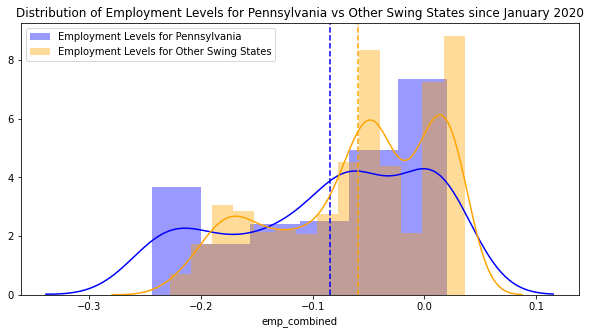

In [54]:
plt.figure(figsize=(10,5))
sns.distplot(s_emp_df['emp_combined'].loc[s_emp_df['stateabbrev']=='PA'], color='blue', label='Employment Levels for Pennsylvania')
plt.axvline(x=s_emp_df['emp_combined'].loc[s_emp_df['stateabbrev']=='PA'].mean(), color='blue', ls='dashed')
sns.distplot(s_emp_df['emp_combined'].loc[s_emp_df['stateabbrev']!='PA'], color='orange', label='Employment Levels for Other Swing States')
plt.axvline(x=s_emp_df['emp_combined'].loc[s_emp_df['stateabbrev']!='PA'].mean(), color='orange', ls='dashed')
plt.title('Distribution of Employment Levels for Pennsylvania vs Other Swing States since January 2020')
plt.legend()
plt.show()

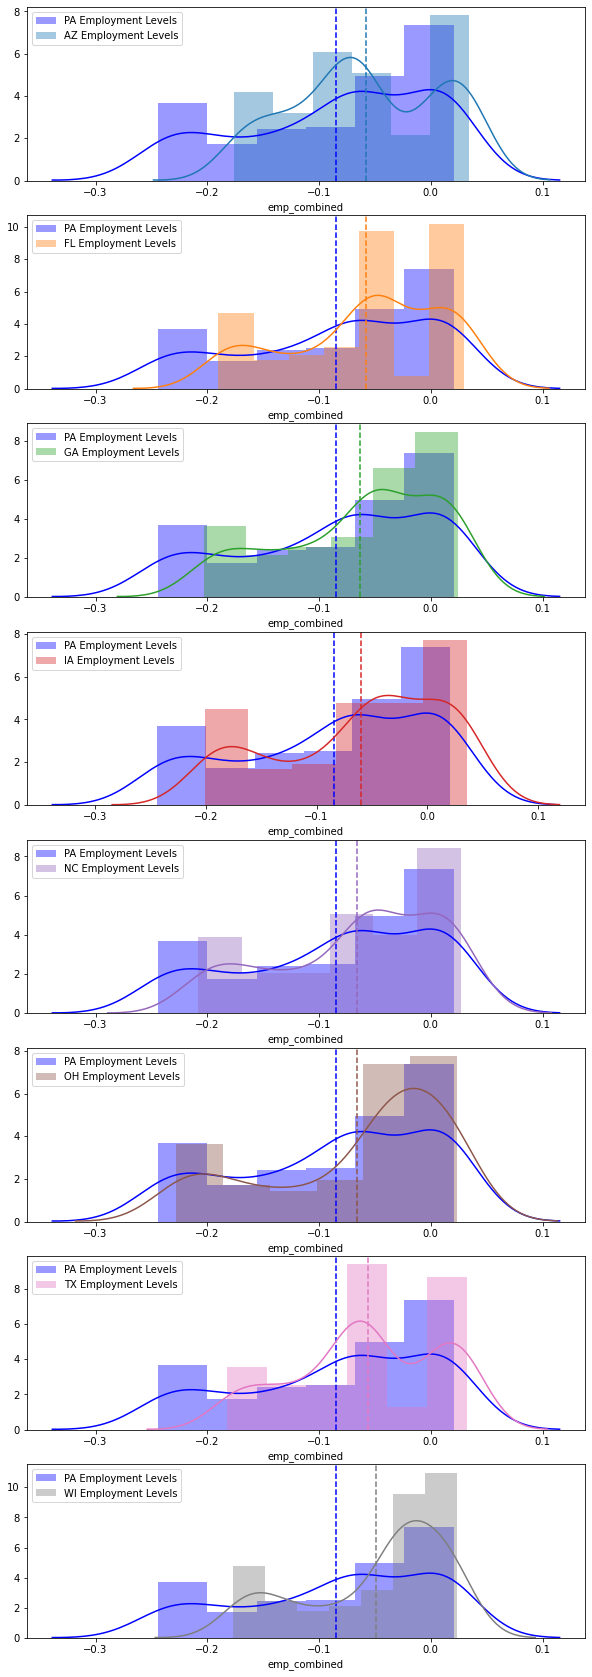

In [55]:
colors = plt.rcParams["axes.prop_cycle"]()
rows = len(s_emp_dict.keys())-1
fig, axes = plt.subplots(rows, 1, figsize=(10, 30))
row = 0
for i in s_emp_dict.keys():
    if i != 'PA':
        c = next(colors)["color"]
        sns.distplot(s_emp_df['emp_combined'].loc[s_emp_df['stateabbrev']=='PA'], color='blue', ax=axes[row], 
                     label='PA Employment Levels')
        axes[row].axvline(x=s_emp_df['emp_combined'].loc[s_emp_df['stateabbrev']=='PA'].mean(), color='blue', 
                    ls='dashed')
        sns.distplot(s_emp_dict[i]['emp_combined'], color=c, ax=axes[row], label='{} Employment Levels'.format(i))
        axes[row].axvline(x=s_emp_dict[i]['emp_combined'].mean(), color=c, 
                    ls='dashed')
        axes[row].legend()
        row += 1
    
plt.show()

From these plots, Pennsylvania has a lower mean value than any of the other swing states in terms of employment levels. This is likely due to the fact that Pennsylvania has a greater distribution of values less than -0.2 compared to the other swing states, which is causing its mean value to be shifted in the negative direction more than other swing states.

When looking at the trends of employment levels, it is clear to see Pennsylvania well below the other swing states throughout the entire year.

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='emp_combined', data=s_emp_dict['PA'], label='Employment Levels for Pennsylvania')
sns.lineplot(x='date', y='emp_combined', data=s_emp_df.loc[s_emp_df['stateabbrev'] != 'PA'], label='Employment Levels for All Other Swing States')
plt.title('Employment Levels for Pennsylvania vs All Other Swing States since January 2020')
plt.legend()
plt.show()

### Research Question 2 Conclusion###

For the job postings distributions, the only swing state that showed any significant difference from the other swings states was Ohio. It only showed this significant difference with two other swing states, Iowa and Georgia. However, when considering its population size and the fact it has one of the worst average job postings in the country, it is likely that Ohio's job posting distribution is statistically different from many of the non-swing states and could play an important role in this coming election.

For the employment levels distribution among swing states, there was a clear outlier and it was Pennsylvania. In the non-parametric tests, it had a p-value that was less than 0.01 for all paired test with the other 8 states, indicating a significant enough difference to reject the null hypotheses that these swing states are equivalent to Pennsylvania. However, due to the non-normal nature of the distribution, it is difficult to quantify this difference. Visualizations best demonstrate this difference as the employment levels for Pennsylvania are on average lower than the other swing states in terms of overall distribution and in terms of yearly trends. 

## Message to Stakeholders and Future Considerations##

As political party operatives, running a successful election campaign requires statistical knowledge in order to understand how and where to target potential voters. Swing states are often the front lines in these political battles and making informed decisions based on the current situation in these states can win elections. However, resources are thin and need to be utilized wisely. That is why concise and tactful campaigning is critical to pick up these states for your candidate and the best way to do that is to know which statistics matter. This report has highlighted two crucial factors in evaluating the strength of the job market across the US, average job postings and employment levels. While both of these variables have suffered from the incursion of COVID, some states have faired worse than others. And due to their strategic value, swings states that experienced a significant difference in these fields could be important campaign targets in order to turn voters.

Through this analysis, two swing states appeared to have significant differences in both of these fields. Ohio has suffered from significantly below average job postings over this past year when compared to two other swing states, Iowa and Georgia. From this information, it can be inferred that while Ohio has the lowest average job postings of the swing states, Iowa and Georgia likely have the highest. Using this knowledge as political party operatives, advertisements displaying promises of more jobs will likely have a bigger impact in the state of Ohio than in the states of Iowa and Georgia for the upcoming election. 

As for the analysis of employment levels, the clear outlier was Pennsylvania, as it showed values significantly less than the other swing states in terms of relative active employment. Voters in Pennsylvania have clearly suffered more than the other swing states when it comes to staying employed during the pandemic. Targeted campaigning strategies that illustrate to voters in Pennsylvania your candidates plan to retain jobs there will likely have a strong impact on the populations voting decision. 

At the moment, this analysis is still very vague. Further inquiry on the different aspects of both job postings and employment levels will need to be explored before making any decision. The Opportunity Insight Economic Tracker repository also include values pertaining to industry, education, and wages for both these fields. Through further analysis, the exact demographics affected the most by the shortage of job postings and lower employment levels can be discovered. This would give even more insight on how to affectively target potential voters for the upcoming 2020 election.